                                        Speaker Identification System

Dataset: https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset (Kaggle)

In [29]:
pip install python_speech_features

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# Import the necessary libraries
import os
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from python_speech_features import mfcc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

Part 1 and 2

In [31]:
# Function to read data
def read_data(folder_path):
    features = []
    labels = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                with wave.open(file_path, 'rb') as wav_file:
                    frames = wav_file.readframes(-1)
                    signal = np.frombuffer(frames, dtype='int16')
                    mfcc_features = mfcc(signal, wav_file.getframerate())
                    features.append(mfcc_features)
                    labels.append(os.path.basename(root))
    return np.array(features), np.array(labels)

In [32]:
# # Set the path to main folder
main_folder_path = "16000_pcm_speeches"

# Read the data
features, labels = read_data(main_folder_path)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [33]:
print(features[0].shape)

(99, 13)


In [34]:
print(X_train.shape), print(X_test.shape), print(y_train.shape), print(y_test.shape)


(6005,)
(1502,)
(6005,)
(1502,)


(None, None, None, None)

Part 3

In [35]:
# Function to create segments of out of order shape data
def make_segments(data, X_train):
    # Define the segment length and step size
    segment_length = X_train[0].shape[0]
    step_size = segment_length # No overlap

    # Initialize an empty list to store the segmented data
    segmented_data = []
    
    # Iterate through the original data to create non-overlapping segments
    for i in range(0, len(data) - segment_length + 1, step_size):
        segment = data[i:i + segment_length, :]
        segmented_data.append(segment)

    # Return the segmented data
    return np.array(segmented_data)

In [36]:
def preprocess_data(X_array, y_array, X_data, y_data, lst_segments, labels):
    # Iterate through the data  
    k=0
    while(k<len(X_data)):
        if X_data[k].shape == (X_data[0].shape[0], X_data[0].shape[1]):
            for i in range(len(X_data[k])):
                    X_array.append(X_data[k][i])
                    y_array.append(y_data[k])
            k+=1
        else:
            # Create segments of the data if the shape is not the same
            segments = make_segments(X_data[k], X_data)
            for j in range(len(segments)):
                lst_segments.append(segments[j]) 
            for j in range(len(segments)):
                labels.append(y_data[k])
            k+=1

In [37]:
def distribute_segments(lst_segments, y_segments, X_train, y_train, X_test, y_test):
    df = pd.DataFrame(list(zip(lst_segments, y_segments)), columns=['X', 'y'])

    # Perform train-test split
    X_train_segments, X_test_segments, y_train_segments, y_test_segments = train_test_split(df['X'], df['y'], test_size=0.2, random_state=42)

    # Add the test and train segments to the original data
    for i in range(len(X_train_segments)):
        for j in range(len(X_train_segments.iloc[i])):
            X_train.append(X_train_segments.iloc[i][j])
            y_train.append(y_train_segments.iloc[i])
            
    for i in range(len(X_test_segments)):
        for j in range(len(X_test_segments.iloc[i])):
            X_test.append(X_test_segments.iloc[i][j])
            y_test.append(y_test_segments.iloc[i])        

In [38]:
# Create empty lists to store the data
l_segments = []
y_segments = []
X_train_array = []
y_train_array = []
X_test_array = []
y_test_array = []

# Preprocess the data
preprocess_data(X_train_array, y_train_array, X_train, y_train,l_segments, y_segments)
preprocess_data(X_test_array, y_test_array, X_test, y_test,l_segments, y_segments) 
# Distribute the segments
distribute_segments(l_segments, y_segments, X_train_array, y_train_array, X_test_array, y_test_array)

# Convert the data to numpy arrays
X_train_array = np.array(X_train_array)
y_train_array = np.array(y_train_array)
X_test_array = np.array(X_test_array)
y_test_array = np.array(y_test_array)

In [39]:
print(X_train_array.shape), print(X_test_array.shape), print(y_train_array.shape), print(y_test_array.shape)

(623304, 13)
(156024, 13)
(623304,)
(156024,)


(None, None, None, None)

In [40]:
# Separate the training data for each speaker
X_train_dict = {}
for i in range(len(y_train_array)):
    if y_train_array[i] in X_train_dict:
        X_train_dict[y_train_array[i]].append(X_train_array[i])
    else:
        X_train_dict[y_train_array[i]] = [X_train_array[i]]

# Make a list of all the speakers
classes = list(X_train_dict.keys())

In [41]:
# Make a list to store the WCSS (Within Cluster Sum of Squares) for each speaker for different no of components
lst = []

# Iterate through the speakers and find optimal the no of components for each speaker
for j in range(len(classes)):
    # Use K-Means clusterning to find the no of components for each speaker using elbow method
    wcss = []
    for i in range(1, 20):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X_train_dict[classes[j]])
        wcss.append(kmeans.inertia_)
    lst.append(wcss)

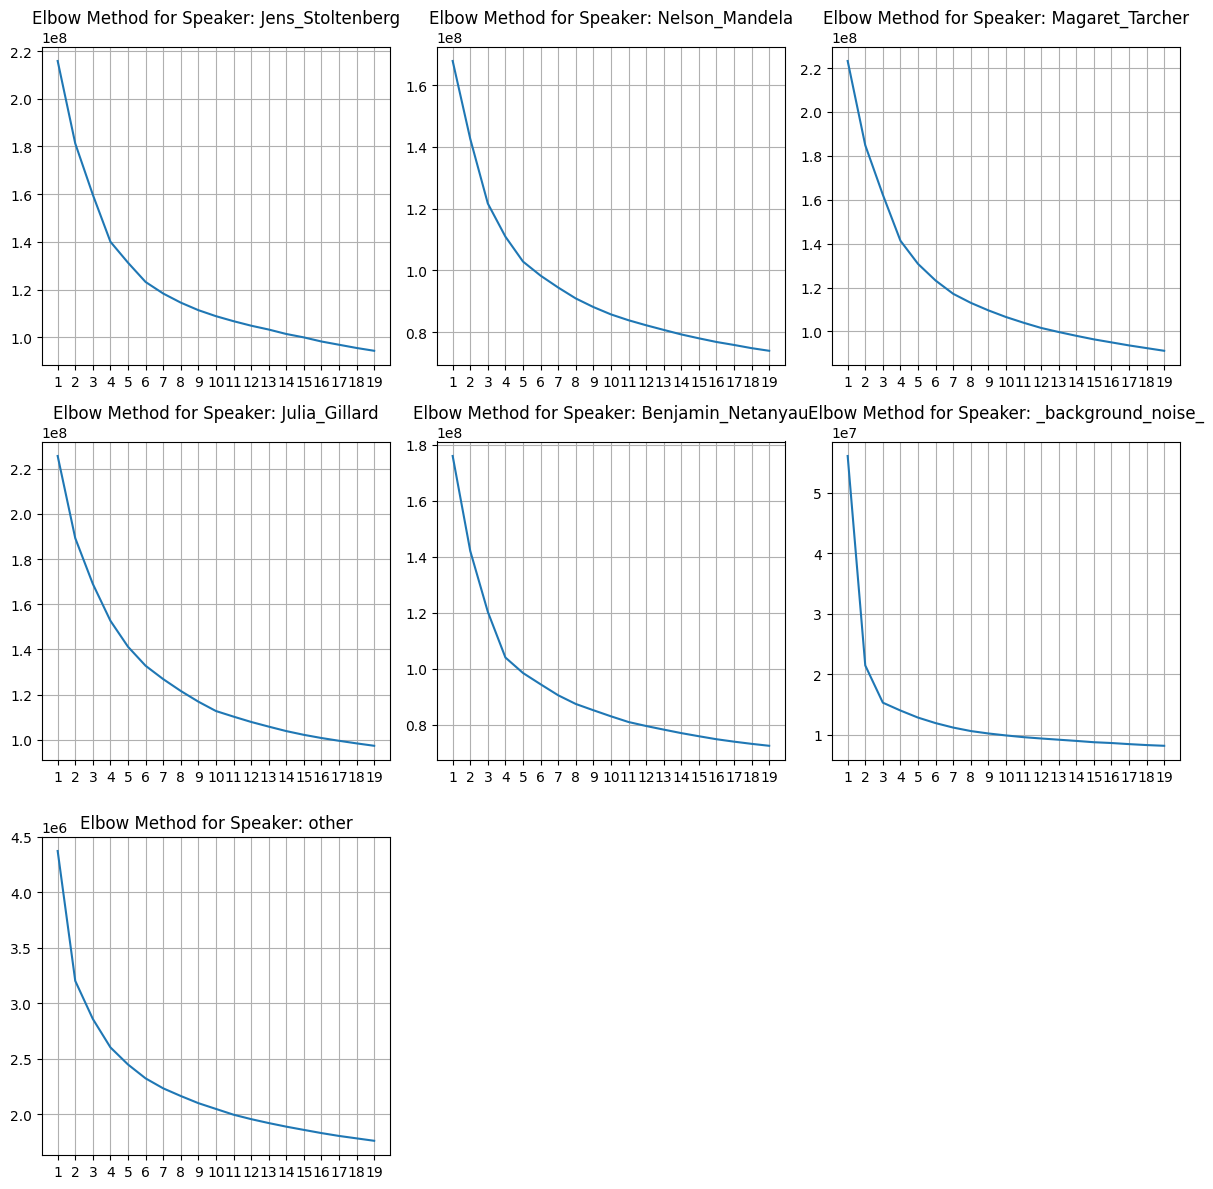

In [42]:
# Plot the elbow method
# Create a figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
x = range(1, 20)
# Set the x-axis ticks
for i in range(3):
    for j in range(3):
        axs[i, j].set_xticks(np.arange(1, 20, 1))

# Show vertical gridlines
for ax in axs.flat:
    ax.grid(True)

# Plot the values for each speaker
axs[0, 0].plot(x, lst[0])
axs[0, 0].set_title('Elbow Method for Speaker: ' + classes[0])

axs[0, 1].plot(x, lst[1])
axs[0, 1].set_title('Elbow Method for Speaker: ' + classes[1])

axs[0, 2].plot(x, lst[2])
axs[0, 2].set_title('Elbow Method for Speaker: ' + classes[2])

axs[1, 0].plot(x, lst[3])
axs[1, 0].set_title('Elbow Method for Speaker: ' + classes[3])

axs[1, 1].plot(x, lst[4])
axs[1, 1].set_title('Elbow Method for Speaker: ' + classes[4])

axs[1, 2].plot(x, lst[5])
axs[1, 2].set_title('Elbow Method for Speaker: ' + classes[5])

axs[2, 0].plot(x, lst[6])
axs[2, 0].set_title('Elbow Method for Speaker: ' + classes[6])

# Hide the empty subplot in the last row and column
axs[2, 1].axis('off')
axs[2, 2].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [43]:
# Implement GMM model for each speaker

# Define the number of components for each speaker's GMM using elbow method on plots obtained above
n_components = [6,5,6,6,4,3,5]

# Initialize GMMs for each speaker
gmm_models = {}
# Iterate through the speakers
i=0
for speaker, data in X_train_dict.items():
    gmm = GaussianMixture(n_components=n_components[i], covariance_type='full', random_state=42)
    # Fit the GMM for each speaker's data
    gmm.fit(data)  
    gmm_models[speaker] = gmm
    i+=1

Part 4

In [44]:
# Resize the test data to fit the GMM model
X_test_array = np.array(X_test_array)
X_test_array.resize(1576, 99, 13)

# Adjust the test labels as per the changes to the test data
window_size = 99
y_test_= []

# Make the changes
for i in range(0, len(y_test_array) - window_size + 1, window_size):
    window = y_test_array[i:i+window_size]
    counter = Counter(window)
    most_common_speaker = counter.most_common(1)[0][0]
    y_test_.append(most_common_speaker)

In [45]:


# Predict the speaker for each test data
predictions = []

# Iterate through the test data
for i in X_test_array:
    scores_per_speaker = []
    for speaker, gmm in gmm_models.items():
        score = gmm.score(i)
        scores_per_speaker.append(score)
    predictions.append(classes[np.argmax(scores_per_speaker)])

print(predictions)


['Julia_Gillard', 'Magaret_Tarcher', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Nelson_Mandela', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Nelson_Mandela', 'Magaret_Tarcher', 'Julia_Gillard', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Benjamin_Netanyau', 'Magaret_Tarcher', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Nelson_Mandela', 'Julia_Gillard', 'Nelson_Mandela', 'Benjamin_Netanyau', 'Nelson_Mandela', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Magaret_T

In [46]:
print(y_test_)

['Julia_Gillard', 'Magaret_Tarcher', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Julia_Gillard', 'Benjamin_Netanyau', 'Nelson_Mandela', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Nelson_Mandela', 'Magaret_Tarcher', 'Julia_Gillard', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Benjamin_Netanyau', 'Magaret_Tarcher', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Nelson_Mandela', 'Julia_Gillard', 'Nelson_Mandela', 'Benjamin_Netanyau', 'Nelson_Mandela', 'Magaret_Tarcher', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Julia_Gillard', 'Julia_Gillard', 'Jens_Stoltenberg', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Magaret_Ta

In [47]:
# Determine the accuracy of prediction
accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == y_test_[i]:
        accuracy += 1
accuracy /= len(predictions)

# Print the accuracy
print('Accuracy: ', accuracy*100, '%')

Accuracy:  99.74619289340102 %
